# 주소데이터 기반 데이터셋 전처리
- 도로명 주소 기반 위경도 처리

In [83]:
import pandas as pd
import requests, json, pprint
from tqdm import tqdm
from geopy.geocoders import Nominatim

geo_local = Nominatim(user_agent='South Korea')

data = pd.read_csv("./company_info.csv", encoding='utf-8')
data.head()

,Unnamed: 0,name,address
0,0,삼성전자,경기도 수원시 영통구 삼성로 129
1,1,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동)
2,2,SK하이닉스,경기도 이천시 부발읍 경충대로 2091 (아미리)
3,4,NAVER,경기도 성남시 분당구 불정로 6
4,5,삼성바이오로직스,인천광역시 연수구 송도바이오대로 300


In [76]:
data_sort = data[data['address'].str.contains("서울")]
data_sort = data_sort[['name', 'address']].reset_index(drop=True)

# 'lat'과 'lon' 열 신규생성
data_sort['lat'] = None
data_sort['lon'] = None

data_sort.head()

,name,address,lat,lon
0,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동),None,None
1,LG화학,서울특별시 영등포구 여의대로 128,None,None
2,현대차,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),None,None
3,기아,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),None,None
4,KB금융,서울특별시 영등포구 국제금융로8길,None,None


Location(국제금융로8길, 여의동, 영등포구, 서울특별시, 07332, 대한민국, (37.51941825, 126.92790455, 0.0))

In [85]:
# 카카오API를 사용하여 좌표->주소 변환
def get_location_kakao(address_data):
  url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address_data
  headers = {"Authorization": "KakaoAK 20953ebae869efd8abdc3657eba800b6"}
  api_json = json.loads(str(requests.get(url,headers=headers).text))
  address = api_json['documents'][0]['address']
  crd = f"{str(address['y'])}, {str(address['x'])}"
  
  return address, crd

def get_location_nominatim(address_data):
  geo = geo_local.geocode(address_data)
  crd = f"{str(geo.latitude)}, {str(geo.longitude)}"
  
  return crd

for idx, i in tqdm(enumerate(range(len(data_sort)))):
  try:
    _, latlon = get_location_kakao(data_sort['address'][i])
    lat, lon = latlon.split(",")
  
  except Exception as e:  # 예외 발생 시 다른 패키지 사용
    try:
      print(f"can't find in kakaoAPI : {data_sort['address'][i]}, try in another package")
      latlon = get_location_nominatim(data_sort['address'][i])
    
    except:
      print(f"SKIP : can't find : {data_sort['address'][i]}")
      lat, lon = None, None  # 좌표를 None으로 설정
    
  # 좌표 값 유효성 확인 후 데이터 저장
  if lat is not None and lon is not None:
      data_sort.at[i, 'lat'] = lat
      data_sort.at[i, 'lon'] = lon

4it [00:00, 16.07it/s]

can't find in kakaoAPI : 서울특별시 영등포구 국제금융로8길 , try in another package


67it [00:05, 12.44it/s]


In [87]:
data_sort.to_csv("./conpany_info_lonlat_add.csv")

# 데이터 별 구역 확인
- 100대 기업의 주소를 기반으로, 회사가 밀집되어있는 구역 5개 선정
- 해당 구역 기반으로 진행예정

In [88]:
display(data_sort)

,name,address,lat,lon
0,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동),37.5251913154781,126.929112756574
1,LG화학,서울특별시 영등포구 여의대로 128,37.5279271045092,126.929241174348
2,현대차,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),37.4643623227152,127.042663599215
3,기아,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),37.4643623227152,127.042663599215
4,KB금융,서울특별시 영등포구 국제금융로8길,37.4643623227152,127.042663599215
...,...,...,...,...
62,아모레G,서울특별시 용산구 한강대로 100 아모레퍼시픽,37.5287911785354,126.968673565462
63,NH투자증권,서울특별시 영등포구 여의대로 108 파크원 NH금융타워(타워2),37.5251913154781,126.929112756574
64,GS건설,서울특별시 종로구 종로 33 그랑서울,37.5709617749066,126.981437983842
65,KCC,서울특별시 서초구 사평대로 344,37.5029945221484,127.020802535605


In [90]:
data_sort['zone_split'] = data_sort['address'].apply(lambda x : x.split(" ")[1])

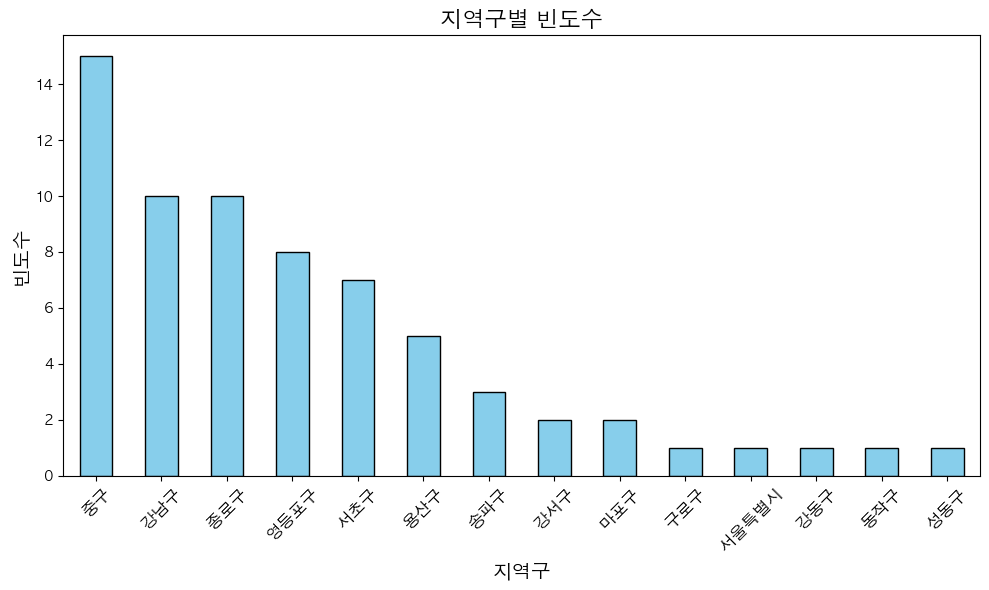

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

platform.system() == "Darwin"
rc('font', family='AppleGothic')  # macOS: 애플고딕

zone_counts = data_sort['zone_split'].value_counts()

# 시각화
plt.figure(figsize=(10, 6))
zone_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('지역구별 빈도수', fontsize=16)
plt.xlabel('지역구', fontsize=14)
plt.ylabel('빈도수', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()